# Chapter 2 Multi-armed Bandits

implementing Prof. Sutton's Reinforcement Learning book contents in python and tensorflow

# 2.3 The 10-armed Testbed

## Figure 2.1
An example bandit problem from the 10-armed testbed. The true value q∗(a) of each of the ten actions was selected according to a normal distribution with mean zero and unit variance, and then the actual rewards were selected according to a mean q∗(a) unit variance normal distribution, as suggested by these gray distributions.

In [40]:
# Figure 2.1

import matplotlib.pyplot as plt
import numpy as np

def draw_bandits(q_stars, r_dist) :
    k = len(q_stars)
    
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    # plot violin plot
    ax.violinplot(r_dist,
                showmeans=False,
                showmedians=True,
                showextrema=False,
                widths=0.3)

    # ax.set_title('Figure 2.1')
    ax.set_xticks([t + 1 for t in range(k)])
    ax.set_xticklabels([t + 1 for t in range(k)])
    for t in range(k) :
        ax.text(t + 1, q_stars[t], 'q*(' + str(t + 1) + ')')

    ax.set_xlabel('Action')
    ax.set_ylabel('Reward distribution')

    ax.plot([0.5, 10.5], [0, 0], linestyle='--', linewidth=1)
    plt.show()


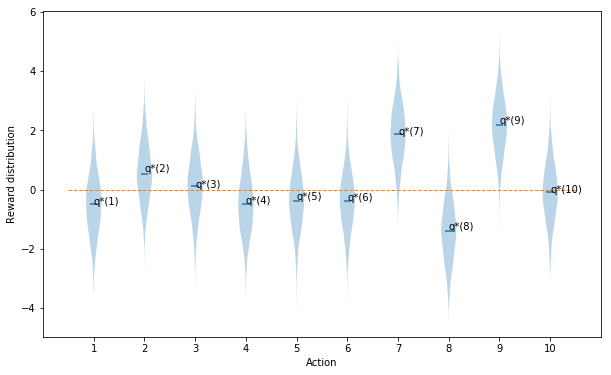

In [43]:
import pickle as pk

# Fixing random state for reproducibility
np.random.seed(9999)

# create and save bandit machines
k = 10

# q_stars will be the action value of each lever selection (now, bandit machine is made !!!)
q_stars = [ np.random.normal() for a in range(k) ]

r_dist = [np.random.normal(q_stars[t], 1.0, 2000) for t in range(k)]

# save generated bandit
pk.dump((q_stars, r_dist), open('10-armed.p', "wb" ))

draw_bandits(q_stars, r_dist)

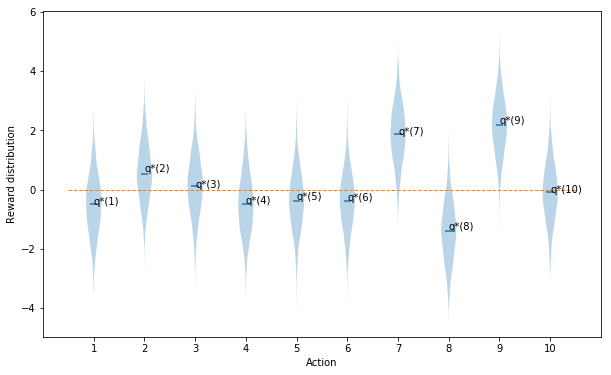

In [44]:
# load saved bandit machines

q_stars, r_dist = pk.load(open('10-armed.p', "rb"))

draw_bandits(q_stars, r_dist)

## Figure 2.2
Average performance of ε-greedy action-value methods on the 10-armed testbed. These data are averages over 2000 runs with different bandit problems. All methods used sample averages as their action-value estimates.

In [193]:
# Figure 2.2

time_steps = 1000

def generate_distributed_random_integers(low, high, size) :
    partition = (high - low) // size
    return [ low + (partition) * i + np.random.randint(0, partition) for i in range(size) ]
    
def select_greedy(values) :
    indices = np.concatenate(np.where(values == values.max()))
    if len(indices) > 1 : # if we remember prev decision, then we can optimize to select by round-robin
        idx = np.random.randint(0, len(indices))
        return indices[idx]
    return indices[0]
    
def single_run(k, q_stars, r_dist, action_policy='greedy', arg=0.0) :    
    # initialize
    n_taken = np.zeros(k, np.int32)
    sum_rewards = np.zeros(k, np.float32)
    values = np.zeros(k, np.float32)

    epsilon = arg if arg is not None else 0.1 # e-greedy epsilon
    rewards = np.zeros(time_steps, np.float32)
    optimal_actions = np.zeros(time_steps, np.float32)

    if False :
        # bandit state simulation. pre-determine each time step states for calculation performance
        bandit_trials = np.stack([np.random.normal(q_stars[i], 1.0, time_steps) for i in range(k)])
    else :
        # choose bandit state from pre-calculated 2000 cases
        bandit_trials = np.stack([r_dist[:, np.random.randint(0, r_dist.shape[1])] for _ in range(time_steps)])
        bandit_trials = np.transpose(bandit_trials)

    explore_count = 0
    optimal_count = 0
    if action_policy == 'e-greedy' :
        explore_steps = generate_distributed_random_integers(0, time_steps, int(time_steps * epsilon))

    for t in range(time_steps) :
        # action selection by policy
        if action_policy == 'e-greedy' :
            if t in explore_steps :
                explore_count = explore_count + 1
                lever = np.random.randint(0, k)
            else :
                lever = select_greedy(values)
        else : # default is greedy
            lever = select_greedy(values)
        reward = bandit_trials[lever, t]
        
        if reward == np.max(bandit_trials[:, t]) : # optimal
            optimal_count = optimal_count + 1
        
        sum_rewards[lever] = sum_rewards[lever] + reward
        n_taken[lever] = n_taken[lever] + 1
        
        # calculate action-values by sample_average method
        values[lever] = sum_rewards[lever] / n_taken[lever]
        
        rewards[t] = reward
        optimal_actions[t] = float(optimal_count) / float(t) * 100.0 if t > 0 else 0.0

    return rewards, optimal_actions

In [194]:
import datetime as dt

num_run = 2000

avg_rs_e0 = np.empty(num_run, dtype=object)
avg_rs_e01 = np.empty(num_run, dtype=object)
avg_rs_e001 = np.empty(num_run, dtype=object)
opt_acts_e0 = np.empty(num_run, dtype=object)
opt_acts_e01 = np.empty(num_run, dtype=object)
opt_acts_e001 = np.empty(num_run, dtype=object)

print('starts running bandits :', dt.datetime.now())

nr_dist = np.stack(r_dist)
for i in range(num_run) :
    avg_rs_e0[i], opt_acts_e0[i] = single_run(k, q_stars, nr_dist, action_policy='greedy')
    avg_rs_e01[i], opt_acts_e01[i] = single_run(k, q_stars, nr_dist, action_policy='e-greedy', arg=0.1)
    avg_rs_e001[i], opt_acts_e001[i] = single_run(k, q_stars, nr_dist, action_policy='e-greedy', arg=0.01)
    
print('finished running bandits :', dt.datetime.now())

starts running bandits : 2018-07-21 18:16:35.394274
finished running bandits : 2018-07-21 18:21:09.107350


In [195]:
m_avg_rs_e0 = np.mean(np.stack(avg_rs_e0), axis=0) # (num_run, time_steps)
m_avg_rs_e01 = np.mean(np.stack(avg_rs_e01), axis=0)
m_avg_rs_e001 = np.mean(np.stack(avg_rs_e001), axis=0)
m_opt_acts_e0 = np.mean(np.stack(opt_acts_e0), axis=0)
m_opt_acts_e01 = np.mean(np.stack(opt_acts_e01), axis=0)
m_opt_acts_e001 = np.mean(np.stack(opt_acts_e001), axis=0)

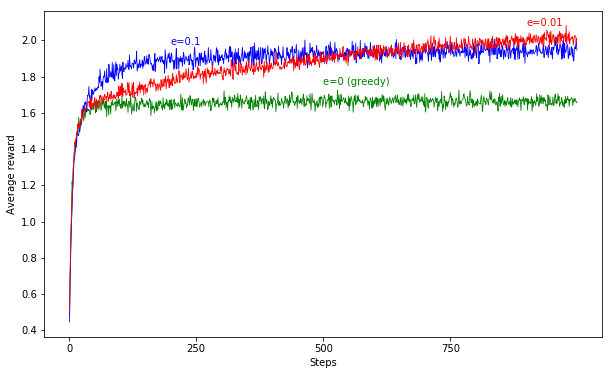

In [212]:
# draw steps - average reward

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

x_interval = 250
ax.set_xticks([x for x in range(0, time_steps, x_interval)])
ax.set_xticklabels([x for x in range(0, time_steps, x_interval)])

x_axis = np.array(range(1, time_steps))
ax.plot(x_axis, m_avg_rs_e0[1:], color='g', lw=0.8, label='greedy')
ax.text(500, m_avg_rs_e0[500] + 0.1, 'e=0 (greedy)', color='g')

ax.plot(x_axis, m_avg_rs_e01[1:], color='b', lw=0.8, label='e-greedy (e=0.1)')
ax.text(200, m_avg_rs_e01[200] + 0.1, 'e=0.1', color='b')

ax.plot(x_axis, m_avg_rs_e001[1:], color='r', lw=0.8, label='e-greedy (e=0.01)')
ax.text(900, m_avg_rs_e001[900] + 0.1, 'e=0.01', color='r')

ax.set_xlabel('Steps')
ax.set_ylabel('Average reward')

plt.show()


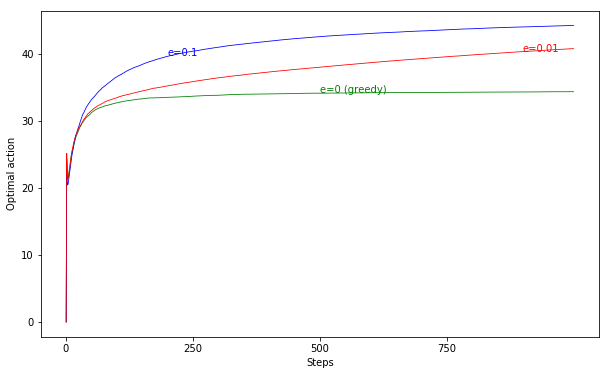

In [214]:
# draw steps - optimal action

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

x_interval = 250
ax.set_xticks([x for x in range(0, time_steps, x_interval)])
ax.set_xticklabels([x for x in range(0, time_steps, x_interval)])

x_axis = np.array(range(1, time_steps + 1))
ax.plot(x_axis, m_opt_acts_e0, color='g', lw=0.8, label='greedy')
ax.text(500, m_opt_acts_e0[500], 'e=0 (greedy)', color='g')

ax.plot(x_axis, m_opt_acts_e01, color='b', lw=0.8, label='e-greedy (e=0.1)')
ax.text(200, m_opt_acts_e01[200], 'e=0.1', color='b')

ax.plot(x_axis, m_opt_acts_e001, color='r', lw=0.8, label='e-greedy (e=0.01)')
ax.text(900, m_opt_acts_e001[900], 'e=0.01', color='r')

ax.set_xlabel('Steps')
ax.set_ylabel('Optimal action')

plt.show()

# 2.4 Incremental Implementation

## A simple bandit algorithm

In [28]:
# A simple bandit algorithm


# 2.5 Tracking a Nonstationary Problem

In [ ]:
# Exercise 2.5


# 2.6 Optimistic Initial Values

In [ ]:
# Figure 2.3


In [ ]:
# Exercise 2.7 : Unbiased Constant-Step-Size Trick


# 2.7 Upper-Confidence-Bound Action Selection

In [ ]:
# Figure 2.4


# 2.8 Gradient Bandit Algorithms

In [ ]:
# Figure 2.5


# 2.10 Summary

In [ ]:
# Figure 2.6


In [ ]:
# Exercise 2.11
